In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns

In [ ]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [96]:


features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','RevLineCr','Term','ApprovalFY','crisis',
    'MIS_Status',
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [80]:
data.columns

Index(['State', 'cat_activites', 'UrbanRural', 'LowDoc', 'bank_loan_float',
       'SBA_loan_float', 'FranchiseCode', 'BankState', 'RevLineCr', 'Term',
       'ApprovalFY', 'DisbursementGross', 'BalanceGross', 'MIS_Status'],
      dtype='object')

In [97]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [98]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [99]:

xgboost = make_pipeline(preprocessor,XGBClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
xgboost.fit(X_train, y_train_encoded)

c:\Users\DELL 7490\Desktop\Projet data\brief_loan\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('xgbclassifier',
                 XGB...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [100]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = xgboost.predict_proba(X_test)[:, 1]
y_pred = xgboost.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', xgboost.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9781151980382335
accuracy 0.9496535694028938
rappel 0.8226460524648334
f1_score 0.851539697635523
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



#### stat meilleur XGBOOST 

AUC-ROC score: 0.9801501116364613
accuracy 0.9520001779418797
rappel 0.8287289316943354
f1_score 0.8583710704206865
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.93      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917

In [101]:
df_rf = pd.DataFrame(xgboost[-1].feature_importances_,xgboost[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__RevLineCr_Y', 'categorical__RevLineCr_`',
       'categorical__RevLineCr_nan', 'ordinal__LowDoc',
       'numeric__bank_loan_float', 'numeric__SBA_loan_float', 'numeric__Term',
       'remainder__UrbanRural', 'remainder__ApprovalFY', 'remainder__crisis'],
      dtype='object', length=2833)

In [84]:
liste_sum = []

for categorical in categorical_column:
    sum_categorical = 0

    for elem in df_rf:
       if categorical in elem:
           sum_categorical += df_rf[elem]

    df_rf[f'sum_{categorical}'] = sum_categorical
    liste_sum.append(f'sum_{categorical}')


In [102]:
liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)

['sum_State', 'sum_cat_activites', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_RevLineCr', 'sum_Term', 'sum_ApprovalFY', 'sum_crisis', 'sum_MIS_Status']


In [103]:
df_rf.sort_values(by= 0,axis=1, ascending=False)

,sum_State,sum_BankState,sum_FranchiseCode,numeric__Term,sum_Term,sum_cat_activites,sum_RevLineCr,categorical__FranchiseCode_1,categorical__BankState_PA,categorical__BankState_VA,remainder__ApprovalFY,sum_ApprovalFY,categorical__BankState_CA,categorical__RevLineCr_0,categorical__BankState_NC,categorical__BankState_MT,sum_UrbanRural,remainder__UrbanRural,categorical__BankState_VT,categorical__BankState_IL,categorical__RevLineCr_Y,categorical__State_FL,categorical__State_VA,categorical__BankState_SC,categorical__BankState_DE,categorical__State_GA,categorical__State_NC,categorical__RevLineCr_T,categorical__BankState_MN,categorical__State_CA,categorical__BankState_OR,categorical__BankState_HI,categorical__cat_activites_62,categorical__BankState_FL,categorical__State_OR,categorical__BankState_MA,categorical__BankState_MD,categorical__cat_activites_33,categorical__BankState_IN,sum_SBA_loan_float,numeric__SBA_loan_float,remainder__crisis,sum_crisis,categorical__State_MN,categorical__BankState_GA,categorical__BankState_OH,categorical__FranchiseCode_78760,categorical__BankState_AL,categorical__BankState_SD,categorical__BankState_IA,categorical__State_OH,categorical__State_ME,categorical__BankState_RI,categorical__State_MI,categorical__BankState_LA,categorical__BankState_NE,categorical__State_AK,sum_LowDoc,ordinal__LowDoc,categorical__cat_activites_54,categorical__cat_activites_21,categorical__State_ND,categorical__State_IL,numeric__bank_loan_float,sum_bank_loan_float,categorical__BankState_WA,categorical__State_WI,categorical__BankState_TX,categorical__BankState_MS,categorical__State_NV,categorical__State_CO,categorical__State_RI,categorical__cat_activites_72,categorical__cat_activites_11,categorical__cat_activites_44,categorical__State_UT,categorical__BankState_NH,categorical__BankState_ND,categorical__RevLineCr_N,categorical__BankState_MI,categorical__BankState_WY,categorical__BankState_KS,categorical__State_CT,categorical__FranchiseCode_52000,categorical__State_AR,categorical__FranchiseCode_68020,categorical__State_AL,categorical__BankState_NY,categorical__State_PA,categorical__State_TX,categorical__BankState_ME,categorical__cat_activites_42,categorical__cat_activites_45,categorical__State_AZ,categorical__FranchiseCode_0,categorical__State_NE,categorical__State_VT,categorical__cat_activites_48,categorical__BankState_nan,categorical__State_NJ,categorical__BankState_OK,categorical__BankState_CT,categorical__BankState_UT,categorical__State_NY,categorical__BankState_NJ,categorical__BankState_CO,categorical__State_WA,categorical__State_MS,categorical__FranchiseCode_25650,categorical__cat_activites_52,categorical__State_SC,categorical__cat_activites_81,categorical__BankState_AR,categorical__State_WY,categorical__State_MT,categorical__State_TN,categorical__BankState_AZ,categorical__State_MA,categorical__State_KS,categorical__FranchiseCode_77174,categorical__BankState_PR,categorical__FranchiseCode_34850,categorical__cat_activites_53,categorical__BankState_NV,categorical__FranchiseCode_89769,categorical__BankState_WV,categorical__State_NM,categorical__State_SD,categorical__FranchiseCode_10528,categorical__cat_activites_0,categorical__BankState_DC,categorical__FranchiseCode_28877,categorical__State_KY,categorical__BankState_TN,categorical__FranchiseCode_73675,categorical__cat_activites_23,categorical__State_LA,categorical__BankState_MO,categorical__FranchiseCode_48400,categorical__cat_activites_56,categorical__FranchiseCode_20550,categorical__FranchiseCode_21425,categorical__cat_activites_49,categorical__FranchiseCode_51720,categorical__BankState_NM,categorical__cat_activites_71,categorical__State_OK,categorical__FranchiseCode_60020,categorical__FranchiseCode_4250,categorical__FranchiseCode_48000,categorical__FranchiseCode_67750,categorical__FranchiseCode_61901,categorical__FranchiseCode_17205,categorical__FranchiseCode_35706,categorical__FranchiseCode_67255,categorical__FranchiseCode_43552,categorical__FranchiseCode_43579,categorical__State_

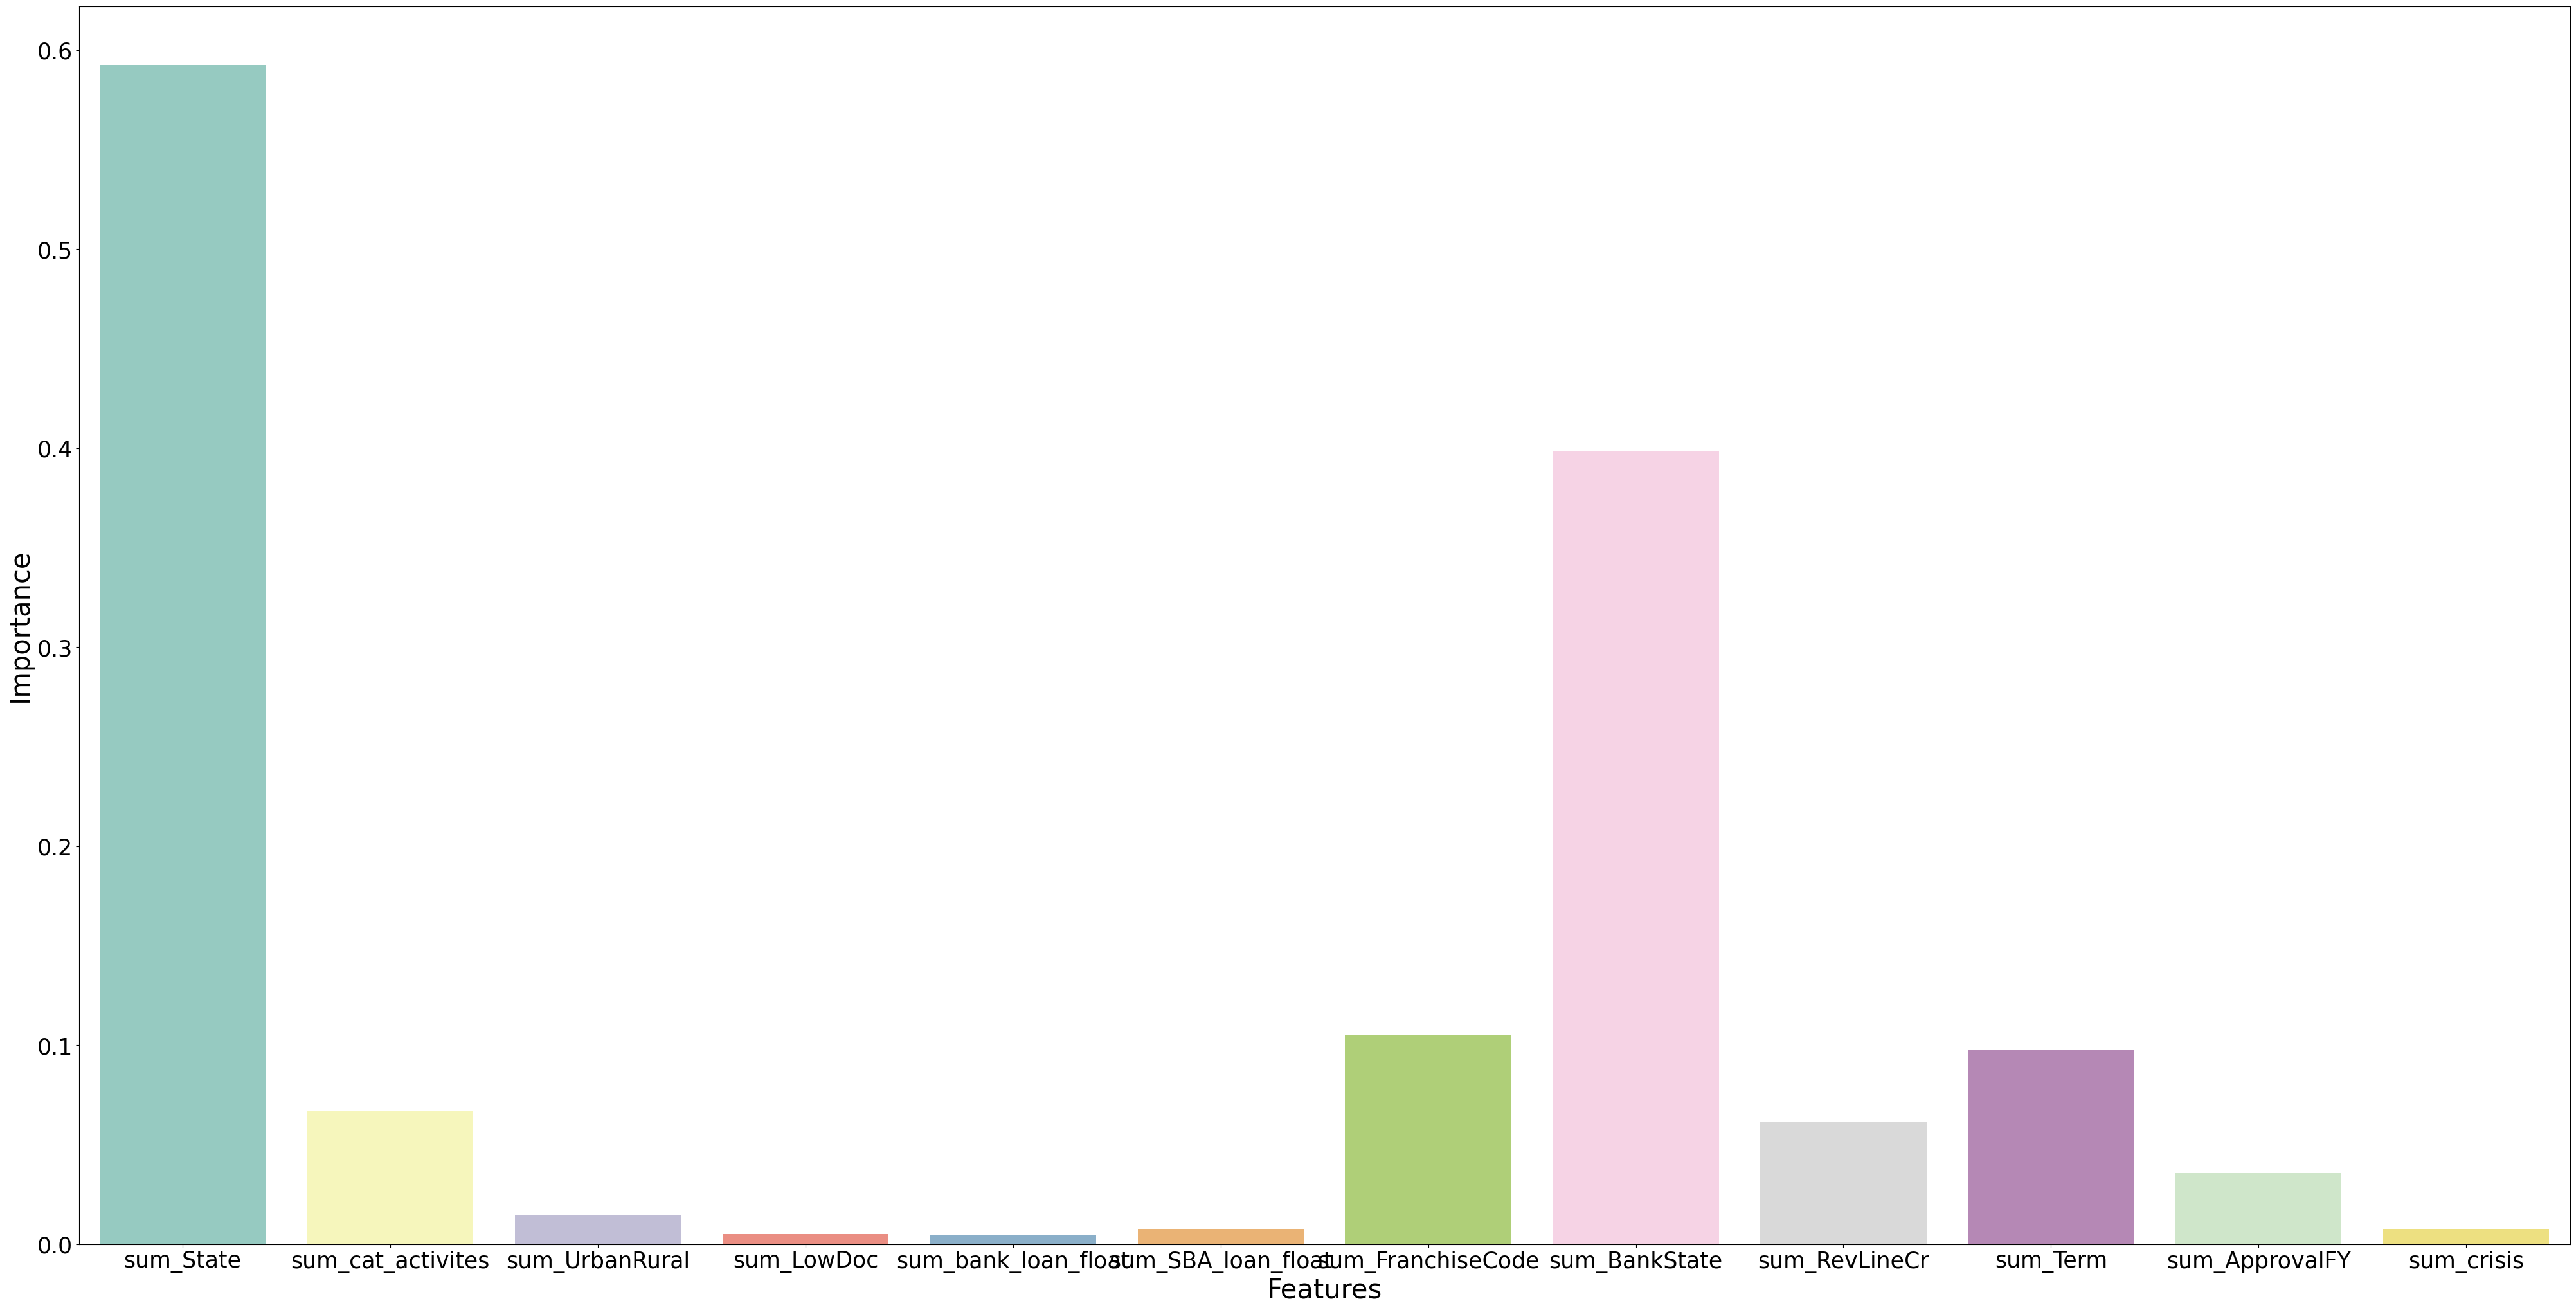

In [107]:


df_rf_graphique = df_rf[liste_sum]


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [46]:
# import pickle
# pickle.dump(xgboost,open('xgboost_lgbm_polyfeatures.pkl','wb'))